In [5]:
!pip install pyathena


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [6]:
!pip install awswrangler 


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [7]:
import awswrangler as wr

In [8]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np

In [9]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name= 'analytics'
table_name = 'daily_check'

In [10]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)

/tmp/ipykernel_18/3429179766.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)


In [11]:
df.head()

,payer,country,date,tx,amount
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55
1,ARGENPER,PERU,2023-04-03,26,4203.70
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00


In [12]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [13]:
# Grouping by 'payer' and 'country' concatenated for this level of granularity
df['payer_country'] = df['payer'] + '_' + df['country']

In [14]:
# Chequeo montos
df['amount'].sum()

25110624454.4149

In [15]:
def aging_filter(df):
    # Find the last date in the sample
    last_date_sample = df['date'].max()

    # Calculate the limit date, one day before the last date in the sample
    limit_date = last_date_sample - pd.Timedelta(days=1)

    # Find the first and last date per 'payer_country' and calculate total_amount and count
    result = (
        df.groupby('payer_country')
        .agg(
            first_date=('date', 'min'),
            last_date=('date', 'max'),
            total_amount=('amount', 'sum'),
            total_transactions=('tx', 'sum')  # Add this line for total_transactions
        )
        .reset_index()
    )

    # Calculate the 'age_payer' variable accurately using the calculated limit_date
    result['age_payer'] = ((limit_date - result['first_date']).dt.days / 30).round(2)

    # Calculate the 'active_payer' variable
    result['active_time'] = ((result['last_date'] - result['first_date']).dt.days / 30).round(2)

    # Calculate the 'inactive' variable
    result['inactive_time'] = ((limit_date - result['last_date']).dt.days / 30).round(2)

    # Sort the final DataFrame by 'total_amount' from highest to lowest
    result = result.sort_values(by='total_amount', ascending=False)

    # Filter the DataFrame based on conditions and return aging_universe
    aging_universe = result.loc[
        (result.age_payer >= 3) & 
        (result.inactive_time <= 3) & 
        (result.total_amount > 10000) & 
        (result.total_transactions > 50)
    ]

    return aging_universe

In [16]:
# Defining Universe
df = df[df['amount'] != 0] # Excluding 0 (flag A & Flag C), defined in EDA

df_aging = aging_filter(df) #Filtering 'payer_country' based on Aging notebook
df_filtered = df[df['payer_country'].isin(df_aging['payer_country'])] # Applying aging filters 

In [17]:
# Date format
df_filtered['date'] = pd.to_datetime(df_filtered['date']).dt.date

/tmp/ipykernel_18/1252395900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date']).dt.date


In [18]:
df_filtered['amount'].sum()

24309892564.970997

In [19]:
df_filtered.head(3)

,payer,country,date,tx,amount,payer_country
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,TRANSFERTO - THUNES_BELGIUM
1,ARGENPER,PERU,2023-04-03,26,4203.70,ARGENPER_PERU
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50,"NAFA_GAMBIA, THE"


In [20]:
df_filtered.shape

(87708, 6)

In [21]:
# CHEQUEO VALORES

In [22]:
df[df['country'] == 'MEXICO']['amount'].sum()

13655009099.1769

In [23]:
val1 = df_filtered[df_filtered['country'] == 'MEXICO']['amount'].sum()
val1

12910028578.262497

In [24]:
val2 = df[df['country'] == 'MEXICO']['amount'].sum() - df_filtered[df_filtered['country'] == 'MEXICO']['amount'].sum()
val2

744980520.9144039

In [25]:
val2/val1

0.0577055671409418

In [26]:
df[df['payer_country'] == 'ELEKTRA (MEXICO)_MEXICO']['amount'].sum()

6397946743.7287

In [27]:
df_filtered[df_filtered['payer_country'] == 'ELEKTRA (MEXICO)_MEXICO']['amount'].sum()

6397946743.7287

In [28]:
df_filtered['country'].unique()

array(['BELGIUM', 'PERU', 'GAMBIA, THE', 'MEXICO', 'HONDURAS', 'NIGERIA',
       'ECUADOR', 'UNITED KINGDOM', 'BRAZIL', 'UNITED STATES',
       'PHILIPPINES', 'EL SALVADOR', 'NICARAGUA', 'GUATEMALA', 'BOLIVIA',
       'HAITI', 'DOMINICAN REPUBLIC', 'UNITED STATES (ATM & DEPOSITS)',
       'COLOMBIA', 'SIERRA LEONE', 'CHILE', 'ARGENTINA', 'BANGLADESH',
       'INDONESIA', 'MALAYSIA', 'GUINEA', 'CAMEROON', 'NEPAL', 'GHANA',
       'INDIA', 'THAILAND', 'FRANCE', 'BURKINA FASO', 'SPAIN', 'PORTUGAL',
       "COTE D'IVOIRE (IVORY COAST)", 'BENIN', 'SENEGAL', 'TOGO',
       'LIBERIA', 'GERMANY', 'JAMAICA', 'MALI', 'ITALY', 'COSTA RICA'],
      dtype=object)

In [29]:
### RATES ###
df_rates=pd.read_csv('rates_completo.csv') # CHEQUEAR FUENTE DE ORIGEN (COMPLETO TRAE TODOS LOS DATOS DDE ORIGEN)

In [30]:
# Selecting columns & renaming
df_rates = df_rates[['feed_date','symbol','feed_price']] 
df_rates = df_rates.rename(columns={'feed_date':'date'})

In [31]:
#df_rates['date'] = pd.to_datetime(df_rates['date']).dt.date
df_rates['date'] = pd.to_datetime(df_rates['date'])

In [32]:
# AHORA hay continuidad de fechas (chequeado, 1023 datos por cada pais desde 01/01/2021 hasta el 21/10/2023)
df_rates['date'].min(), df_rates['date'].max()

(Timestamp('2021-01-01 01:00:27'), Timestamp('2023-10-22 03:38:26'))

In [33]:
# Function to keep last register, per day
import matplotlib.pyplot as plt
def get_closing_prices(data, start_date, end_date):
    # Convert the 'FEED_DATE' column to datetime type if it is not already
    data['date'] = pd.to_datetime(data['date'])

    # Filter by date range
    data_filtered = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

    # Sort by 'FEED_DATE' to ensure that the data is in chronological order
    data_filtered = data_filtered.sort_values(by='date')

    # Group by 'SYMBOL' and 'FEED_DATE', taking the last value of 'FEED_PRICE'
    data_grouped = data_filtered.groupby(['symbol', pd.Grouper(key='date', freq='D')])['feed_price'].last().reset_index()
    
 # Generate evolution plots for each SYMBOL
    for symbol in data_grouped['symbol'].unique():
        symbol_data = data_grouped[data_grouped['symbol'] == symbol]

        plt.figure(figsize=(10, 6))
        plt.plot(symbol_data['date'], symbol_data['feed_price'], label=symbol)
        plt.title(f'Closing prices evolution for {symbol}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()
    
    return data_grouped

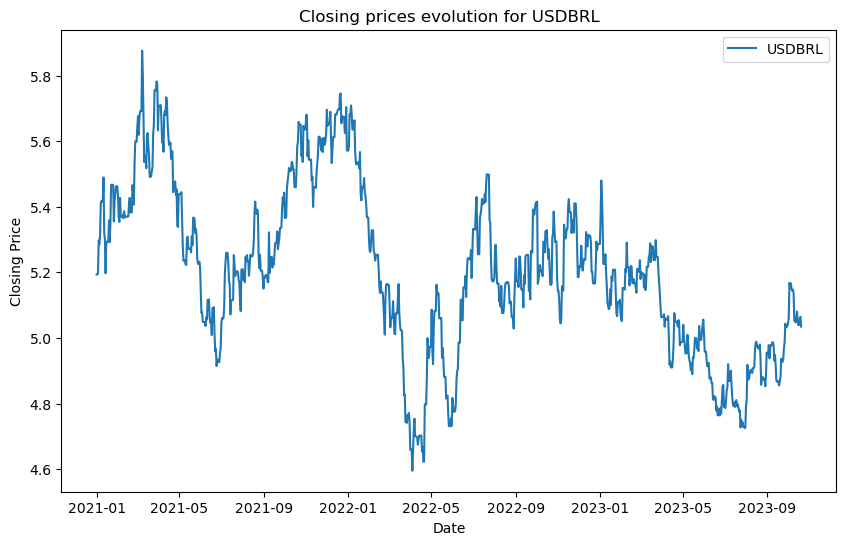

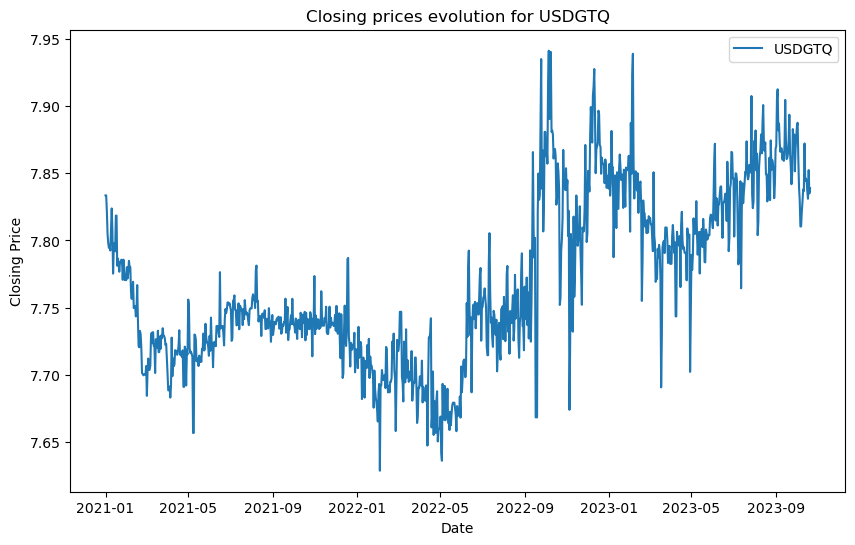

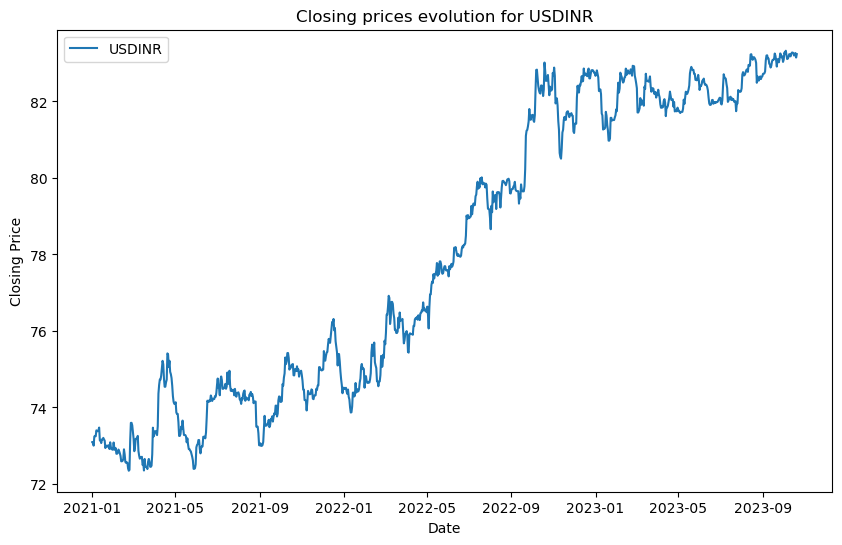

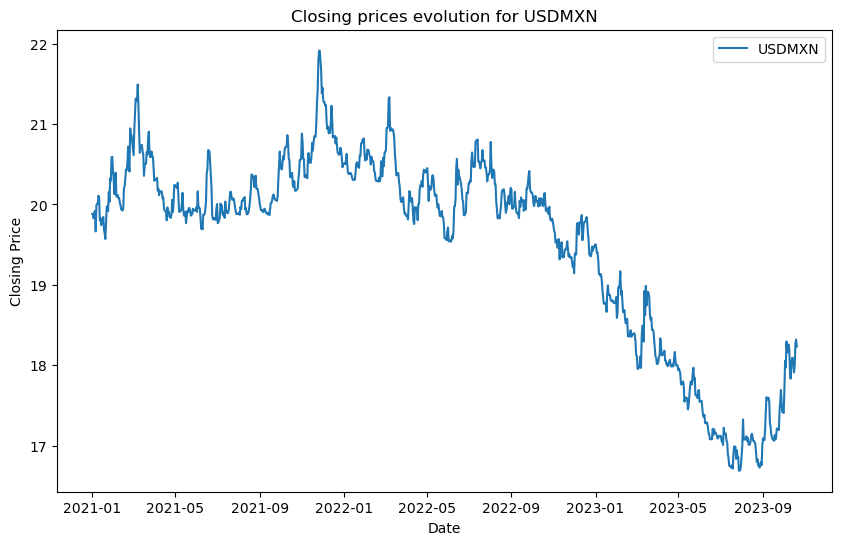

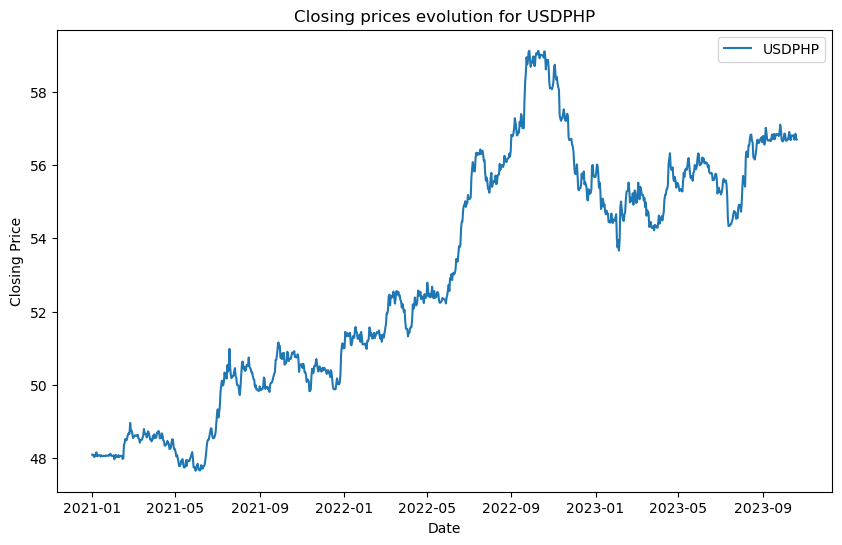

In [34]:
start_date = '2021-01-01'
end_date = '2023-10-21'

rates = get_closing_prices(df_rates, start_date, end_date)

In [35]:
rates.head(20)

,symbol,date,feed_price
0,USDBRL,2021-01-01,5.1934
1,USDBRL,2021-01-02,5.1934
2,USDBRL,2021-01-03,5.1975
3,USDBRL,2021-01-04,5.2972
4,USDBRL,2021-01-05,5.2855
5,USDBRL,2021-01-06,5.3143
6,USDBRL,2021-01-07,5.4104
7,USDBRL,2021-01-08,5.4180
8,USDBRL,2021-01-09,5.4154
9,USDBRL,2021-01-10,5.4185


In [36]:
#Date format
#rates['date'] = rates['date'].dt.date

In [37]:
# Generating an empty df with date continuity and currency included in rates df
from itertools import product

def generate_continuous_dates(data):
    # Obtener la lista única de monedas y fechas disponibles
    countries = data['symbol'].unique()
    dates = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')

    # Generar todas las combinaciones de países y fechas continuas
    all_dates = list(product(countries, dates))
    continuous_dates = pd.DataFrame(all_dates, columns=['symbol', 'date'])

    return continuous_dates

In [38]:
rates_cont = generate_continuous_dates(rates)

In [39]:
##1023 days x 5 countries= 5115
rates_cont.shape

(5115, 2)

In [40]:
rates_cont.isna().sum()

symbol    0
date      0
dtype: int64

In [41]:
rates_cont = pd.merge(rates_cont, rates, on=['symbol', 'date'], how='left')

In [42]:
rates_cont[rates_cont['date'] > '2021-12-27'].sort_values('date')

,symbol,date,feed_price
361,USDBRL,2021-12-28,5.6286
3430,USDMXN,2021-12-28,20.6646
2407,USDINR,2021-12-28,74.7363
4453,USDPHP,2021-12-28,50.8455
1384,USDGTQ,2021-12-28,7.7313
...,...,...,...
4091,USDMXN,2023-10-20,18.2351
2045,USDGTQ,2023-10-20,7.8388
1022,USDBRL,2023-10-20,5.0345
3068,USDINR,2023-10-20,83.2396


In [43]:
#NOW IT MAKES NO SENSE SINCE THERE ARE NO MISSINGS
# Sorting by date and country for proper forward filling
rates_cont = rates_cont.sort_values(by=['symbol', 'date'])
# Filling missing values downward within each country group
rates_cont['feed_price'] = rates_cont.groupby('symbol')['feed_price'].fillna(method='ffill')

/tmp/ipykernel_18/305076726.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rates_cont['feed_price'] = rates_cont.groupby('symbol')['feed_price'].fillna(method='ffill')


In [44]:
rates_cont[rates_cont['date'] > '2021-12-26'].sort_values('date').head(20) # OK! 

,symbol,date,feed_price
360,USDBRL,2021-12-27,5.6254
3429,USDMXN,2021-12-27,20.7050
2406,USDINR,2021-12-27,74.9377
4452,USDPHP,2021-12-27,50.2775
1383,USDGTQ,2021-12-27,7.7211
2407,USDINR,2021-12-28,74.7363
3430,USDMXN,2021-12-28,20.6646
4453,USDPHP,2021-12-28,50.8455
361,USDBRL,2021-12-28,5.6286
1384,USDGTQ,2021-12-28,7.7313


In [45]:
rates_cont[rates_cont['date'] > '2023-01-22'].sort_values('date').head(20) # OK! 

,symbol,date,feed_price
752,USDBRL,2023-01-23,5.2082
2798,USDINR,2023-01-23,81.5729
3821,USDMXN,2023-01-23,18.8103
4844,USDPHP,2023-01-23,54.4597
1775,USDGTQ,2023-01-23,7.8526
753,USDBRL,2023-01-24,5.1398
2799,USDINR,2023-01-24,81.5724
3822,USDMXN,2023-01-24,18.8012
1776,USDGTQ,2023-01-24,7.8406
4845,USDPHP,2023-01-24,54.6760


In [46]:
rates_cont.head()

,symbol,date,feed_price
0,USDBRL,2021-01-01,5.1934
1,USDBRL,2021-01-02,5.1934
2,USDBRL,2021-01-03,5.1975
3,USDBRL,2021-01-04,5.2972
4,USDBRL,2021-01-05,5.2855


In [47]:
###WE OBTAIN THE LAGS OF UP TO 7 DAYS FOR THE EXCHANGE RATE 
for i in range(1, 8):
        nombre_columna = f'feed_price_retardo_{i}'
        rates_cont[nombre_columna] = rates_cont.groupby('symbol')['feed_price'].shift(i)

In [48]:
rates_cont.head()

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,USDBRL,2021-01-01,5.1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDBRL,2021-01-02,5.1934,5.1934,NaN,NaN,NaN,NaN,NaN,NaN
2,USDBRL,2021-01-03,5.1975,5.1934,5.1934,NaN,NaN,NaN,NaN,NaN
3,USDBRL,2021-01-04,5.2972,5.1975,5.1934,5.1934,NaN,NaN,NaN,NaN
4,USDBRL,2021-01-05,5.2855,5.2972,5.1975,5.1934,5.1934,NaN,NaN,NaN


In [49]:
rates_cont['var_rate_lag1']=rates_cont.feed_price_retardo_1-rates_cont.feed_price_retardo_2
rates_cont['var_rate_lag2']=rates_cont.feed_price_retardo_2-rates_cont.feed_price_retardo_3
rates_cont['var_rate_lag3']=rates_cont.feed_price_retardo_3-rates_cont.feed_price_retardo_4
rates_cont['var_rate_lag4']=rates_cont.feed_price_retardo_4-rates_cont.feed_price_retardo_5
rates_cont['var_rate_lag5']=rates_cont.feed_price_retardo_5-rates_cont.feed_price_retardo_6
rates_cont['var_rate_lag6']=rates_cont.feed_price_retardo_6-rates_cont.feed_price_retardo_7

In [50]:
rates_cont.head()

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
0,USDBRL,2021-01-01,5.1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDBRL,2021-01-02,5.1934,5.1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USDBRL,2021-01-03,5.1975,5.1934,5.1934,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN
3,USDBRL,2021-01-04,5.2972,5.1975,5.1934,5.1934,NaN,NaN,NaN,NaN,0.0041,0.0000,NaN,NaN,NaN,NaN
4,USDBRL,2021-01-05,5.2855,5.2972,5.1975,5.1934,5.1934,NaN,NaN,NaN,0.0997,0.0041,0.0,NaN,NaN,NaN


In [51]:
# Filling NaN?
rates_cont.isna().sum()
#rates_cont=rates_cont.fillna(method='bfill')
#rates_cont=rates_cont.fillna(method='ffill')

symbol                   0
date                     0
feed_price               0
feed_price_retardo_1     5
feed_price_retardo_2    10
feed_price_retardo_3    15
feed_price_retardo_4    20
feed_price_retardo_5    25
feed_price_retardo_6    30
feed_price_retardo_7    35
var_rate_lag1           10
var_rate_lag2           15
var_rate_lag3           20
var_rate_lag4           25
var_rate_lag5           30
var_rate_lag6           35
dtype: int64

In [52]:
rates_dict = {
    'USDBRL': 'BRAZIL', # Bz Real 
    'USDINR': 'INDIA', # Indian Rupia
    'USDGTQ': 'GUATEMALA', #Quetzal 
    'USDMXN': 'MEXICO', #Mx Peso
    'USDPHP': 'PHILIPPINES' # Ph Peso
}

In [53]:
rates_cont['country'] = rates_cont['symbol'].map(rates_dict)

In [54]:
rates_cont['country'].unique()

array(['BRAZIL', 'GUATEMALA', 'INDIA', 'MEXICO', 'PHILIPPINES'],
      dtype=object)

In [55]:
rates_cont

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6,country
0,USDBRL,2021-01-01,5.1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRAZIL
1,USDBRL,2021-01-02,5.1934,5.1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRAZIL
2,USDBRL,2021-01-03,5.1975,5.1934,5.1934,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,BRAZIL
3,USDBRL,2021-01-04,5.2972,5.1975,5.1934,5.1934,NaN,NaN,NaN,NaN,0.0041,0.0000,NaN,NaN,NaN,NaN,BRAZIL
4,USDBRL,2021-01-05,5.2855,5.2972,5.1975,5.1934,5.1934,NaN,NaN,NaN,0.0997,0.0041,0.0000,NaN,NaN,NaN,BRAZIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,USDPHP,2023-10-16,56.6998,56.8162,56.8095,56.8095,56.8105,56.6812,56.7680,56.9060,0.0067,0.0000,-0.0010,0.1293,-0.0868,-0.1380,PHILIPPINES
5111,USDPHP,2023-10-17,56.6960,56.6998,56.8162,56.8095,56.8095,56.8105,56.6812,56.7680,-0.1164,0.0067,0.0000,-0.0010,0.1293,-0.0868,PHILIPPINES
5112,USDPHP,2023-10-18,56.8562,56.6960,56.6998,56.8162,56.8095,56.8095,56.8105,56.6812,-0.0038,-0.1164,0.0067,0.0000,-0.0010,0.1293,PHILIPPINES
5113,USDPHP,2023-10-19,56.7388,56.8562,56.6960,56.6998,56.8162,56.8095,56.8095,56.8105,0.1602,-0.0038,-0.1164,0.0067,0.0000,-0.0010,PHILIPPINES


In [56]:
df_filtered

,payer,country,date,tx,amount,payer_country
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,TRANSFERTO - THUNES_BELGIUM
1,ARGENPER,PERU,2023-04-03,26,4203.70,ARGENPER_PERU
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50,"NAFA_GAMBIA, THE"
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50,WALDOS (APPRIZA)_MEXICO
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00,BANPAIS (RED CHAPINA)_HONDURAS
...,...,...,...,...,...,...
101965,BANCO INDUSTRIAL,GUATEMALA,2021-01-02,2005,981210.84,BANCO INDUSTRIAL_GUATEMALA
101966,BANCOLOMBIA,COLOMBIA,2021-11-16,476,178977.17,BANCOLOMBIA_COLOMBIA
101967,BANCO DE CREDITO DEL PERU - BCP (UT),PERU,2023-01-23,199,66060.00,BANCO DE CREDITO DEL PERU - BCP (UT)_PERU
101968,CHEDRAUI (APPRIZA),MEXICO,2022-08-12,23,5437.21,CHEDRAUI (APPRIZA)_MEXICO


In [57]:
#Date format
rates_cont['date'] = rates_cont['date'].dt.date

In [58]:
# Combined df  containing only the rows that match both the 'date' and 'country' columns in both df (df_filtered and rates).
# WARNING!!! Includes only common columns [date, country] > Check rates_dict
df1 = pd.merge(df_filtered, rates_cont, on=['date', 'country'], how='left')

In [59]:
df1['date'] = pd.to_datetime(df1['date']).dt.date

In [60]:
df1['amount'].sum()

24309892564.970997

In [61]:
df1

,payer,country,date,tx,amount,payer_country,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,...,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,TRANSFERTO - THUNES_BELGIUM,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARGENPER,PERU,2023-04-03,26,4203.70,ARGENPER_PERU,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50,"NAFA_GAMBIA, THE",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50,WALDOS (APPRIZA)_MEXICO,USDMXN,17.0075,16.7580,16.7970,...,16.7283,16.7544,16.7544,16.8330,-0.0390,0.0169,0.0518,-0.0261,0.0000,-0.0786
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00,BANPAIS (RED CHAPINA)_HONDURAS,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87703,BANCO INDUSTRIAL,GUATEMALA,2021-01-02,2005,981210.84,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.8335,7.8335,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87704,BANCOLOMBIA,COLOMBIA,2021-11-16,476,178977.17,BANCOLOMBIA_COLOMBIA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87705,BANCO DE CREDITO DEL PERU - BCP (UT),PERU,2023-01-23,199,66060.00,BANCO DE CREDITO DEL PERU - BCP (UT)_PERU,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87706,CHEDRAUI (APPRIZA),MEXICO,2022-08-12,23,5437.21,CHEDRAUI (APPRIZA)_MEXICO,USDMXN,19.8282,19.9453,20.0311,...,20.2496,20.4145,20.4330,20.4299,-0.0858,-0.2215,0.0030,-0.1649,-0.0185,0.0031


In [62]:
### EFFECT OF CANCELED TRANSACTIONS ###

In [63]:
table2_name = 'daily_sales_count_cancelled_v2'##WE LOAD THE BASE WITH CANCELLATIONS
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)

/tmp/ipykernel_18/1193640667.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)


In [64]:
df2['date'] = pd.to_datetime(df2['date']).dt.date

In [65]:
df2.head()

,payer,country,date,amount,tx_cancelled
0,BANCO BISA,BOLIVIA,2023-08-10,7737.00,1
1,TELEDOLAR-NIC (TN),NICARAGUA,2023-10-19,77198.00,15
2,BANCOLOMBIA,COLOMBIA,2023-10-19,422854.61,84
3,DAVIVIENDA,COLOMBIA,2023-10-19,166348.73,61
4,OXXO (TN),MEXICO,2022-10-29,45036.40,62


In [66]:
###ORDERED BY: COUNTRY, PAYER, DATE

In [67]:
df2=df2.sort_values(by=['country', 'payer', 'date'])

In [68]:
df2.head()

,payer,country,date,amount,tx_cancelled
801,AFEX,ARGENTINA,2021-08-05,0.0,1
19019,AFEX,ARGENTINA,2021-08-06,0.0,1
41888,ARGENPER,ARGENTINA,2020-12-31,70.0,0
28966,ARGENPER,ARGENTINA,2021-01-02,25.0,0
1625,ARGENPER,ARGENTINA,2021-01-05,490.0,0


In [69]:
##ONCE THE DATASET HAS BEEN SORTED, WE CAN OBTAIN THE LAGS OF THE CANCELLED TX

In [70]:
for i in range(1, 8):
    nombre_columna = f'tx_cancelled_{i}'
    df2[nombre_columna] = df2.groupby(['country', 'payer'])['tx_cancelled'].shift(i)

In [71]:
##NOTE THAT IT BRINGS THE NUMBER OF CANCELLATIONS FOR THE LAST AVAILABLE DATA (I.E. THE PREVIOUS ROW)
df_prueba=df2.loc[df2.country=='MEXICO']
df_prueba.tail(20)

,payer,country,date,amount,tx_cancelled,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7
9633,WALMART (UT),MEXICO,2023-10-05,473442.39,61,74.0,64.0,54.0,48.0,62.0,51.0,34.0
69362,WALMART (UT),MEXICO,2023-10-06,605532.85,46,61.0,74.0,64.0,54.0,48.0,62.0,51.0
100212,WALMART (UT),MEXICO,2023-10-07,597892.70,42,46.0,61.0,74.0,64.0,54.0,48.0,62.0
37868,WALMART (UT),MEXICO,2023-10-08,438368.94,56,42.0,46.0,61.0,74.0,64.0,54.0,48.0
84371,WALMART (UT),MEXICO,2023-10-09,331874.13,32,56.0,42.0,46.0,61.0,74.0,64.0,54.0
95140,WALMART (UT),MEXICO,2023-10-10,310515.78,46,32.0,56.0,42.0,46.0,61.0,74.0,64.0
71332,WALMART (UT),MEXICO,2023-10-11,265200.61,39,46.0,32.0,56.0,42.0,46.0,61.0,74.0
86580,WALMART (UT),MEXICO,2023-10-12,282657.10,40,39.0,46.0,32.0,56.0,42.0,46.0,61.0
33767,WALMART (UT),MEXICO,2023-10-13,474161.67,43,40.0,39.0,46.0,32.0,56.0,42.0,46.0
46596,WALMART (UT),MEXICO,2023-10-14,591180.36,49,43.0,40.0,39.0,46.0,32.0,56.0,42.0


In [72]:
df2['var_tx_cancelled_1']=df2.tx_cancelled_1-df2.tx_cancelled_2
df2['var_tx_cancelled_2']=df2.tx_cancelled_2-df2.tx_cancelled_3
df2['var_tx_cancelled_3']=df2.tx_cancelled_3-df2.tx_cancelled_4
df2['var_tx_cancelled_4']=df2.tx_cancelled_4-df2.tx_cancelled_5
df2['var_tx_cancelled_5']=df2.tx_cancelled_5-df2.tx_cancelled_6
df2['var_tx_cancelled_6']=df2.tx_cancelled_6-df2.tx_cancelled_7

In [73]:
df2.head()

,payer,country,date,amount,tx_cancelled,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
801,AFEX,ARGENTINA,2021-08-05,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19019,AFEX,ARGENTINA,2021-08-06,0.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41888,ARGENPER,ARGENTINA,2020-12-31,70.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28966,ARGENPER,ARGENTINA,2021-01-02,25.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1625,ARGENPER,ARGENTINA,2021-01-05,490.0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [74]:
df_prueba2=df2.loc[df2.country=='MEXICO']
df_prueba2.head()

,payer,country,date,amount,tx_cancelled,tx_cancelled_1,tx_cancelled_2,tx_cancelled_3,tx_cancelled_4,tx_cancelled_5,tx_cancelled_6,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6
26559,24XORO,MEXICO,2023-02-22,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7661,24XORO,MEXICO,2023-02-24,0.0,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21780,24XORO,MEXICO,2023-02-28,20.0,3,3.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
12906,24XORO,MEXICO,2023-03-01,25.0,2,3.0,3.0,1.0,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN
45572,24XORO,MEXICO,2023-03-15,4000.0,0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,-1.0,0.0,2.0,NaN,NaN,NaN


In [75]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101970 entries, 801 to 28289
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   payer               101970 non-null  object 
 1   country             101970 non-null  object 
 2   date                101970 non-null  object 
 3   amount              101970 non-null  float64
 4   tx_cancelled        101970 non-null  int64  
 5   tx_cancelled_1      101671 non-null  float64
 6   tx_cancelled_2      101397 non-null  float64
 7   tx_cancelled_3      101141 non-null  float64
 8   tx_cancelled_4      100896 non-null  float64
 9   tx_cancelled_5      100663 non-null  float64
 10  tx_cancelled_6      100444 non-null  float64
 11  tx_cancelled_7      100230 non-null  float64
 12  var_tx_cancelled_1  101397 non-null  float64
 13  var_tx_cancelled_2  101141 non-null  float64
 14  var_tx_cancelled_3  100896 non-null  float64
 15  var_tx_cancelled_4  100663 non-null  f

In [76]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87708 entries, 0 to 87707
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   payer                 87708 non-null  object 
 1   country               87708 non-null  object 
 2   date                  87708 non-null  object 
 3   tx                    87708 non-null  int64  
 4   amount                87708 non-null  float64
 5   payer_country         87708 non-null  object 
 6   symbol                33744 non-null  object 
 7   feed_price            33744 non-null  float64
 8   feed_price_retardo_1  33720 non-null  float64
 9   feed_price_retardo_2  33694 non-null  float64
 10  feed_price_retardo_3  33665 non-null  float64
 11  feed_price_retardo_4  33637 non-null  float64
 12  feed_price_retardo_5  33608 non-null  float64
 13  feed_price_retardo_6  33581 non-null  float64
 14  feed_price_retardo_7  33553 non-null  float64
 15  var_rate_lag1      

In [77]:
df_final = pd.merge(df1,df2, on=['date','payer','country', 'amount'])

In [78]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [79]:
df_final['amount'].sum()

24309892564.970997

In [80]:
### DUMMIES ####

In [81]:
# Weekday indicator (dummy)
df_final['weekday'] = (df_final['date'].dt.dayofweek < 4).astype(int)

In [82]:
#WE ADD ONE MORE DAY AFTER CHRISTMAS, NEW YEAR'S EVE AND US INDEPENDENCE (BETTER CAPTURES THE DISTURBANCE).
# Special dates list - Format: Month-day 
special_dates_list = [ '07-04', #US independence day 
                      '12-25', #Christmas
                      '05-11' # Mexico & Colombia - Mother's day
                     '01-01', #New Year
                     '01-02',
                     '12-26',
                     '07-05'] 

# Applying format process special_dates function
special_dates_list_processed = [(int(date.split('-')[0]), int(date.split('-')[1])) for date in special_dates_list]

In [83]:
# To check special dates defined by list
def mark_special_dates(row):
    if (row['date'].month, row['date'].day) in special_dates_list_processed:
        return 1
    else:
        return 0

In [84]:
# Marking special dates in df
df_final['special_dates'] = df_final.apply(lambda row: mark_special_dates(row), axis=1)

In [85]:
df_final.shape

(87708, 37)

In [86]:
df_final['amount'].sum()

24309892564.970997

In [87]:
df_final.head()

,payer,country,date,tx,amount,payer_country,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,...,tx_cancelled_6,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,weekday,special_dates
0,TRANSFERTO - THUNES,BELGIUM,2023-04-03,1,55.55,TRANSFERTO - THUNES_BELGIUM,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,ARGENPER,PERU,2023-04-03,26,4203.70,ARGENPER_PERU,NaN,NaN,NaN,NaN,...,4.0,2.0,-6.0,0.0,0.0,3.0,-1.0,2.0,1,0
2,NAFA,"GAMBIA, THE",2023-04-03,8,1086.50,"NAFA_GAMBIA, THE",NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1,0
3,WALDOS (APPRIZA),MEXICO,2023-08-31,14,4797.50,WALDOS (APPRIZA)_MEXICO,USDMXN,17.0075,16.758,16.797,...,1.0,2.0,-1.0,0.0,-1.0,-1.0,3.0,-1.0,1,0
4,BANPAIS (RED CHAPINA),HONDURAS,2021-05-06,43,17493.00,BANPAIS (RED CHAPINA)_HONDURAS,NaN,NaN,NaN,NaN,...,3.0,0.0,-2.0,5.0,0.0,-2.0,-1.0,3.0,1,0


In [88]:
# Checking amount differences between initial universe and final dataframe
def country_check(df, df_final):
    unique_countries = df_final['country'].unique()
    results = []

    for country in unique_countries:
        total_universe = df[df['country'] == country]['amount'].sum()
        total_abt = df_final[df_final['country'] == country]['amount'].sum()
        difference = total_universe - total_abt
        perc = (1 - total_abt / total_universe) * 100

        results.append({
            'Country': country,
            'Initial Amount': total_universe,
            'ABT Amount': total_abt,
            'Diff Initial-ABT': difference,
            '% Diff': perc
        })

    return pd.DataFrame(results)

# Usage:
country_totals = country_check(df, df_final)


In [89]:
country_totals[country_totals['Country'].isin(rates_dict.values())]

,Country,Initial Amount,ABT Amount,Diff Initial-ABT,% Diff
3,MEXICO,1.365501e+10,1.291003e+10,7.449805e+08,5.455731
8,BRAZIL,7.296333e+08,7.296333e+08,0.000000e+00,0.000000
10,PHILIPPINES,6.902826e+08,6.902826e+08,0.000000e+00,0.000000
13,GUATEMALA,5.804712e+09,5.804710e+09,2.089670e+03,0.000036
29,INDIA,6.678685e+06,6.521721e+06,1.569641e+05,2.350224


In [90]:
### ME QUEDO POR AHORA SOLAMENTE CON LO QUE TIENE VALORES EN RATES ###

In [91]:
#df_ABT1 = df_final[df_final['country'].isin(rates_dict.values())]
#df_ABT1['amount'].sum(), len(df_ABT1)

In [92]:
#df_ABT2 = df_final[~df_final['symbol'].isnull()]
#df_ABT2['amount'].sum(), len(df_ABT2)

In [93]:
#df_final[~df_final['symbol'].isnull()]['country'].unique()

In [94]:
# EL PROBLEMA ESTARIA EN QUE HAY RATES NULOS PARA ALGUNAS FECHAS/PAISES
# SOLUCIONADO

In [95]:
##META AL 5/01/2024 OBTENER LA BASE CON UNIVERSO DEFINIDO Y VARIABLES DE FECHAS ESPECIALES, DIAS, MONTOS, VAR RATES Y VARIACIONES DE TX_CANCELLED

In [96]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87708 entries, 0 to 87707
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   payer                 87708 non-null  object        
 1   country               87708 non-null  object        
 2   date                  87708 non-null  datetime64[ns]
 3   tx                    87708 non-null  int64         
 4   amount                87708 non-null  float64       
 5   payer_country         87708 non-null  object        
 6   symbol                33744 non-null  object        
 7   feed_price            33744 non-null  float64       
 8   feed_price_retardo_1  33720 non-null  float64       
 9   feed_price_retardo_2  33694 non-null  float64       
 10  feed_price_retardo_3  33665 non-null  float64       
 11  feed_price_retardo_4  33637 non-null  float64       
 12  feed_price_retardo_5  33608 non-null  float64       
 13  feed_price_retar

In [97]:
df_final.payer_country.nunique()

130

In [98]:
### Combining payer and country, we can obtain a column to work on 
# We can enconde it to obtain better results
from sklearn.preprocessing import LabelEncoder
# Inicializar LabelEncoder
label_encoder = LabelEncoder()
# Codificar ‘PAYER_COUNTRY’ como valores numéricos únicos
df_final['payer_country_encoder'] = label_encoder.fit_transform(df_final['payer_country'])

In [99]:
df_final.payer_country_encoder.nunique()

130

In [100]:
#df_consulta=df_final.loc[df_final.payer=='ELEKTRA (MEXICO)']
#df_consulta
##ELEKTRA MÉXICO TIENE EL ITEM_ID==57
df_consulta=df_final.loc[(df_final.payer=='BANCO INDUSTRIAL') & (df_final.country=='GUATEMALA')]
df_consulta
##BANCO INDUSTRAIL DE GUATEMALA TIENE EL ITEM_ID==24

,payer,country,date,tx,amount,payer_country,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,...,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,weekday,special_dates,payer_country_encoder
310,BANCO INDUSTRIAL,GUATEMALA,2022-02-17,2167,1234160.10,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.6870,7.6919,7.6870,...,111.0,-43.0,42.0,-10.0,-10.0,29.0,-7.0,1,0,24
557,BANCO INDUSTRIAL,GUATEMALA,2021-09-04,3814,1979140.06,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.7394,7.7394,7.7336,...,149.0,50.0,-8.0,-29.0,-31.0,-13.0,1.0,0,0,24
1412,BANCO INDUSTRIAL,GUATEMALA,2023-07-22,7961,4076555.45,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.8454,7.8489,7.8737,...,206.0,50.0,-37.0,-10.0,-38.0,-69.0,65.0,0,0,24
1643,BANCO INDUSTRIAL,GUATEMALA,2022-08-15,4407,2549921.51,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.7592,7.7487,7.7385,...,184.0,38.0,45.0,44.0,-38.0,8.0,-61.0,1,0,24
2131,BANCO INDUSTRIAL,GUATEMALA,2021-01-18,2562,1349597.56,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.7812,7.8185,7.8184,...,99.0,7.0,47.0,6.0,-14.0,0.0,-19.0,1,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87433,BANCO INDUSTRIAL,GUATEMALA,2021-07-16,3111,1606685.45,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.7505,7.7515,7.7339,...,126.0,7.0,-31.0,-30.0,12.0,16.0,-12.0,0,0,24
87497,BANCO INDUSTRIAL,GUATEMALA,2023-07-30,7831,4418577.28,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.8289,7.8240,7.8341,...,237.0,70.0,26.0,-37.0,4.0,-53.0,-32.0,0,0,24
87527,BANCO INDUSTRIAL,GUATEMALA,2022-06-02,2588,1647573.50,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.6871,7.7062,7.6682,...,93.0,-17.0,4.0,-44.0,6.0,53.0,37.0,1,0,24
87545,BANCO INDUSTRIAL,GUATEMALA,2022-03-08,2728,1607511.69,BANCO INDUSTRIAL_GUATEMALA,USDGTQ,7.6942,7.6986,7.7469,...,122.0,-22.0,-2.0,21.0,37.0,-6.0,-14.0,1,0,24


In [101]:
df_consulta2=df_final.loc[df_final.payer_country_encoder==12]
df_consulta2.head(2)

,payer,country,date,tx,amount,payer_country,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,...,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,weekday,special_dates,payer_country_encoder
53,BANCO ATLANTIDA,HONDURAS,2023-10-05,1083,322778.68,BANCO ATLANTIDA_HONDURAS,NaN,NaN,NaN,NaN,...,34.0,-5.0,-27.0,13.0,-19.0,35.0,25.0,1,0,12
313,BANCO ATLANTIDA,HONDURAS,2022-11-07,888,357425.13,BANCO ATLANTIDA_HONDURAS,NaN,NaN,NaN,NaN,...,66.0,2.0,-2.0,17.0,-6.0,-3.0,-10.0,1,0,12


In [102]:
####GENERATE A FILE WITH THE VARIABLES ITEM_ID, TIMESTAMP AND VALUE (AMOUNT) FOR AWS FORECAST##

In [103]:
target_ts_amount=df_final.loc[:, ['payer_country_encoder', 'date', 'amount']]
target_ts_amount.rename(columns={'payer_country_encoder': 'item_id', 'date': 'timestamp', 'amount': 'target_value'}, inplace=True)
target_ts_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87708 entries, 0 to 87707
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   item_id       87708 non-null  int64         
 1   timestamp     87708 non-null  datetime64[ns]
 2   target_value  87708 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 MB


In [104]:
target_ts_amount.head()
##yyyy MM dd in timestamp##

,item_id,timestamp,target_value
0,106,2023-04-03,55.55
1,9,2023-04-03,4203.70
2,89,2023-04-03,1086.50
3,124,2023-08-31,4797.50
4,33,2021-05-06,17493.00


In [105]:
###GENERATE THE DATASET OF RELATED TIME SERIES (UP TO 23 VARIABLES+ID_ITEM+TIMESTAMP-FIRST THESE TWO VARIABLES)

In [106]:
related_ts_ds=df_final.loc[:, ['payer_country_encoder', 'date','var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6', 'var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6', 'tx', 'weekday', 'special_dates']]

In [107]:
related_ts_ds.rename(columns={'payer_country_encoder': 'item_id', 'date': 'timestamp'}, inplace=True)
del related_ts_ds['tx']
related_ts_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87708 entries, 0 to 87707
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   item_id             87708 non-null  int64         
 1   timestamp           87708 non-null  datetime64[ns]
 2   var_rate_lag1       33694 non-null  float64       
 3   var_rate_lag2       33665 non-null  float64       
 4   var_rate_lag3       33637 non-null  float64       
 5   var_rate_lag4       33608 non-null  float64       
 6   var_rate_lag5       33581 non-null  float64       
 7   var_rate_lag6       33553 non-null  float64       
 8   var_tx_cancelled_1  87510 non-null  float64       
 9   var_tx_cancelled_2  87404 non-null  float64       
 10  var_tx_cancelled_3  87289 non-null  float64       
 11  var_tx_cancelled_4  87175 non-null  float64       
 12  var_tx_cancelled_5  87065 non-null  float64       
 13  var_tx_cancelled_6  86952 non-null  float64   

In [108]:
##EXPORTO LOS CSV##
target_ts_amount['timestamp'] = target_ts_amount['timestamp'].dt.date
target_ts_amount.timestamp.head()

0    2023-04-03
1    2023-04-03
2    2023-04-03
3    2023-08-31
4    2021-05-06
Name: timestamp, dtype: object

In [109]:
related_ts_ds['timestamp'] = pd.to_datetime(related_ts_ds['timestamp'])
related_ts_ds['timestamp'] = related_ts_ds['timestamp'].dt.date
related_ts_ds.timestamp.head()

0    2023-04-03
1    2023-04-03
2    2023-04-03
3    2023-08-31
4    2021-05-06
Name: timestamp, dtype: object

In [110]:
##TIME SERIE WITH TARGET##
##target_ts_amount.to_csv('target_ts_amount.csv')

In [111]:
##TIME SERIES RELATED##
##related_ts_ds.to_csv('related_ts_ds.csv')

In [112]:
###END ABT TASK FOR AWS FORECAST##

In [114]:
df_final.payer_country.nunique()

130

In [107]:
####ROUTINES FOR EXPORTING CSV TO VIAMERICAS S3##


###NO OLVIDAR CREAR EL CSV CON METADATA!!

In [343]:
wr.s3.to_csv(
    df=target_ts_amount,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/target/target_abt.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/target/target_abt.csv'],
 'partitions_values': {}}

In [107]:
wr.s3.to_csv(
    df=related_ts_ds,
    path='s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/related_ts_ds_abt.csv',
    dataset=False,
    index=False
)

{'paths': ['s3://viamericas-datalake-dev-us-east-1-283731589572-analytics/Forecast/related_ts_ds/related_ts_ds_abt.csv'],
 'partitions_values': {}}

In [116]:
# Agrupamos por 'payer' y 'country', y sumamos 'amount'
grouped_data = df.groupby(['payer', 'country']).agg({'amount': 'sum'}).reset_index()

# Obtenemos el top 10 de payers por país para todo el período
top10_payers = grouped_data.nlargest(10, 'amount')

print(top10_payers)

                             payer      country        amount
76                ELEKTRA (MEXICO)       MEXICO  6.397947e+09
34             BANCOPPEL (APPRIZA)       MEXICO  3.345583e+09
42                  BANRURAL (RYT)    GUATEMALA  2.928455e+09
27                BANCO INDUSTRIAL    GUATEMALA  2.286921e+09
45           BBVA - BANCOMER (BTS)       MEXICO  6.632710e+08
80      ENVIOS CON CLABE (APPRIZA)       MEXICO  6.113105e+08
38                    BANORTE (UT)       MEXICO  4.787224e+08
23              BANCO DE OCCIDENTE     HONDURAS  4.383592e+08
153  TELECOMM TELEGRAFOS (APPRIZA)       MEXICO  4.355922e+08
24              BANCO DE ORO (BDO)  PHILIPPINES  4.348228e+08


In [123]:
df_consulta3=df_final.loc[df_final.payer=='BANORTE (UT)']
##BBVA - BANCOMER (BTS) id==38
##BANCOPPEL (APPRIZA) id==29
##ENVIOS CON CLABE (APPRIZA) ID==60
##BANORTE id=

In [124]:
df_consulta3.head(2)

,payer,country,date,tx,amount,payer_country,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,...,tx_cancelled_7,var_tx_cancelled_1,var_tx_cancelled_2,var_tx_cancelled_3,var_tx_cancelled_4,var_tx_cancelled_5,var_tx_cancelled_6,weekday,special_dates,payer_country_encoder
211,BANORTE (UT),MEXICO,2021-01-02,408,260039.81,BANORTE (UT)_MEXICO,USDMXN,19.8822,19.8822,NaN,...,NaN,-17.0,NaN,NaN,NaN,NaN,NaN,0,1,32
305,BANORTE (UT),MEXICO,2023-08-06,1166,810206.35,BANORTE (UT)_MEXICO,USDMXN,17.0776,17.0785,17.0785,...,39.0,-19.0,20.0,-9.0,14.0,-30.0,33.0,0,0,32


In [269]:
df_elektra = df_final[df_final['payer_country'] == 'ELEKTRA (MEXICO)_MEXICO']

In [270]:
df_elektra['amount'].sum()

6397946743.728701

In [97]:
#df_elektra.to_csv('ABT_elektra.csv')

In [99]:
#df_Mexico = df_ABT1[df_ABT1['country'] == 'MEXICO']

In [271]:
#df_Mexico.head()

In [104]:
#df_Mexico.columns

Index(['payer', 'country', 'date', 'tx', 'amount', 'payer_country',
       'encoded_payer_country', 'symbol', 'feed_price', 'feed_price_retardo_1',
       'feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4',
       'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7',
       'var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4',
       'var_rate_lag5', 'var_rate_lag6', 'tx_cancelled', 'tx_cancelled_1',
       'tx_cancelled_2', 'tx_cancelled_3', 'tx_cancelled_4', 'tx_cancelled_5',
       'tx_cancelled_6', 'tx_cancelled_7', 'var_tx_cancelled_1',
       'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4',
       'var_tx_cancelled_5', 'var_tx_cancelled_6', 'weekday', 'special_dates'],
      dtype='object')

In [118]:
columns_to_group = ['tx','amount', 'tx_cancelled', 'tx_cancelled_1',
       'tx_cancelled_2', 'tx_cancelled_3', 'tx_cancelled_4', 'tx_cancelled_5',
       'tx_cancelled_6', 'tx_cancelled_7', 'var_tx_cancelled_1',
       'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4',
       'var_tx_cancelled_5', 'var_tx_cancelled_6']

In [272]:
#df_Mexico.drop(['country', 'payer'], axis=1).groupby('date')[columns_to_group].sum()

In [119]:
#ABT_Mex = df_Mexico.drop(['country', 'payer'], axis=1).groupby('date')[columns_to_group].sum()

In [120]:
#df_Mexico.to_csv('ABT_MEXICO.csv')

In [133]:
#df_Mexico[df_Mexico['date'] == '2021-01-01']['var_tx_cancelled_3'].sum()

122.0

In [122]:
#ABT_Mex.reset_index(inplace = True)

In [273]:
#ABT_Mex[ABT_Mex['date'] == '2021-01-01']